In [103]:
import Pkg

# List of external packages to install
# Note: LinearAlgebra and SparseArrays are standard libraries included 
# with Julia, so they do not need to be installed separately.
packages = [
    "BoundaryValueDiffEq",
    "ModelingToolkit",
    "MethodOfLines",
    "DifferentialEquations",
    "NonlinearSolve",
    "DomainSets",
    "FFTW",
    "Plots",
    "BifurcationKit",
    "LinearAlgebra",
    "SparseArrays",
    "Setfield",
]

# Add the packages
Pkg.add(packages)

   Resolving package versions...
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Manifest.toml`


In [104]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using NonlinearSolve
using DomainSets
using FFTW
using Plots
using BifurcationKit
using Setfield 

In [105]:
# 1. Define the ODE Function
function driven_oscillator!(du, u, p, t)
    # u[1] = x, u[2] = v
    du[1] = u[2]
    # Equation: m*x'' + c*x' + k*x = F*cos(omega*t)
    du[2] = (p.F * cos(p.omega * t) - p.c * u[2] - p.k * u[1]) / p.m
end

# 2. Parameters

par_osc = (m = 1.0, k = 1.0, c = 0.01, F = 0.5, omega = 0.5)

(m = 1.0, k = 1.0, c = 0.01, F = 0.5, omega = 0.5)

In [106]:
# 3. Define the Poincaré Return Map manually
# This function calculates: F(u) = u(T) - u(0)
# When F(u) = 0, we have found a periodic orbit.
function poincare_map(u, p)
    T = 2π / p.omega
    
    # We integrate from 0 to T starting at u
    prob = ODEProblem(driven_oscillator!, u, (0.0, T), p)
    
    # Solve the ODE
    sol = solve(prob, RK4(), reltol=1e-9, abstol=1e-9, save_everystep=false)
    
    # Return the difference (displacement) after one loop
    return sol[end] - u
end

poincare_map (generic function with 1 method)

In [107]:
# 4. Define the Bifurcation Problem 
# guess the starting position 
u0 = [1.0, 2.0]

prob = BifurcationProblem(poincare_map, u0, par_osc, (@optic _.omega);

    record_from_solution = (x, p; k...) -> begin
        
        # 1. robustly determine the current omega
        current_omega = (p isa Real) ? p : p.omega
        
        # 2. Manually rebuild the full parameter tuple
        p_full = (m=par_osc.m, k=par_osc.k, c=par_osc.c, F=par_osc.F, omega=Float64(current_omega))

        # 3. Calculate period T
        T = 2π / p_full.omega
        
        # 4. Re-integrate to measure the maximum amplitude
        prob_rec = ODEProblem(driven_oscillator!, x, (0.0, T), p_full)
        sol_rec = solve(prob_rec, Tsit5(), reltol=1e-8, abstol=1e-8)
        
        # Return max |x|
        return maximum(abs.(sol_rec[1, :]))
    end
)

┌─ Bifurcation Problem with uType Vector{Float64}
├─ Inplace: false
├─ Dimension: 2
├─ Symmetric: false
└─ Parameter: omega

In [108]:
# 5. Continuation Options
opts = ContinuationPar(
    p_min = 0.1, 
    p_max = 3.0,     
    ds = 0.02,       # Step size
    max_steps = 10000,
    detect_bifurcation = 0 
)

ContinuationPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  dsmin: Float64 0.0001
  dsmax: Float64 0.1
  ds: Float64 0.02
  a: Float64 0.5
  p_min: Float64 0.1
  p_max: Float64 3.0
  max_steps: Int64 10000
  newton_options: NewtonPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  η: Float64 150.0
  save_to_file: Bool false
  save_sol_every_step: Int64 1
  nev: Int64 3
  save_eig_every_step: Int64 1
  save_eigenvectors: Bool true
  plot_every_step: Int64 10
  tol_stability: Float64 1.0e-10
  detect_fold: Bool true
  detect_bifurcation: Int64 0
  dsmin_bisection: Float64 1.0e-16
  n_inversion: Int64 2
  max_bisection_steps: Int64 25
  tol_bisection_eigenvalue: Float64 1.0e-16
  detect_event: Int64 0
  tol_param_bisection_event: Float64 1.0e-16
  detect_loop: Bool false


In [109]:
# 6. Perform Continuation
# use PALC to trace the curve
branch = continuation(prob, PALC(), opts)

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 797
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter omega starts at 0.5, ends at 3.0
 ├─ Algo: PALC [Secant]
 └─ Special points:

- #  1, endpoint at omega ≈ +3.00000000,                                                                     step = 796


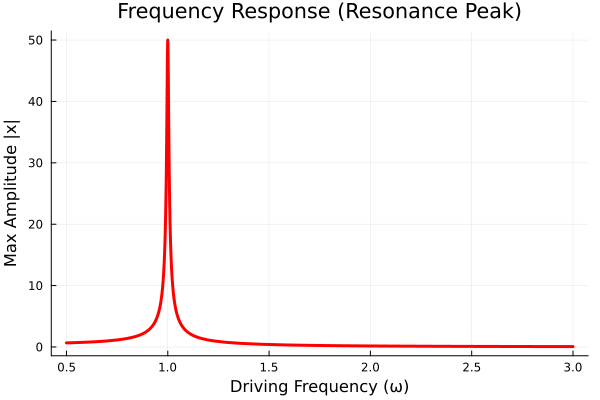

In [110]:
# 7. Plotting
plot(branch, 
    title = "Frequency Response (Resonance Peak)",
    xlabel = "Driving Frequency (ω)",
    ylabel = "Max Amplitude |x|",
    lw = 3, color = :red, 
    legend = false
)